In [1]:
import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import glob
import os
from pathlib import Path

%matplotlib inline
plt.rcParams["figure.figsize"] = (7,5)

In [14]:
models = (
    ("GarNet", h5py.File("/eos/user/m/mushahid/cms-ad/src/output/garnet_2_layers_test/output.h5", 'r'), glob.glob("../signals/signals_scaled2/*")),
    # ("GarNet", h5py.File("/eos/user/m/mushahid/cms-ad/src/output/garnet_2_layers_test2/output.h5", 'r'), glob.glob("../signals/signals_scaled2/*")),
    # ("GarNet (HLS)", h5py.File("/eos/user/m/mushahid/cms-ad/src/hls_out3/predictions.h5", 'r'), glob.glob("../signals_scaled2/*")),
)

features = ("η", "ϕ", "pT")

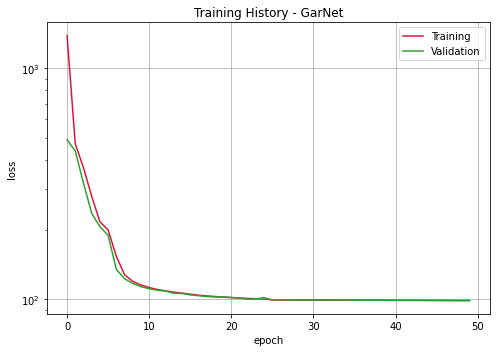

In [10]:
def plot_training_history(model_output, title):
    loss = model_output['loss'][:]
    val_loss = model_output['val_loss'][:]
    
    plt.figure()
    plt.plot(loss, color="crimson")
    plt.plot(val_loss, color="tab:green")
    plt.title("Training History - %s"%title)

    plt.semilogy()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.grid(True)

for model in models:
    plot_training_history(model[1], model[0])

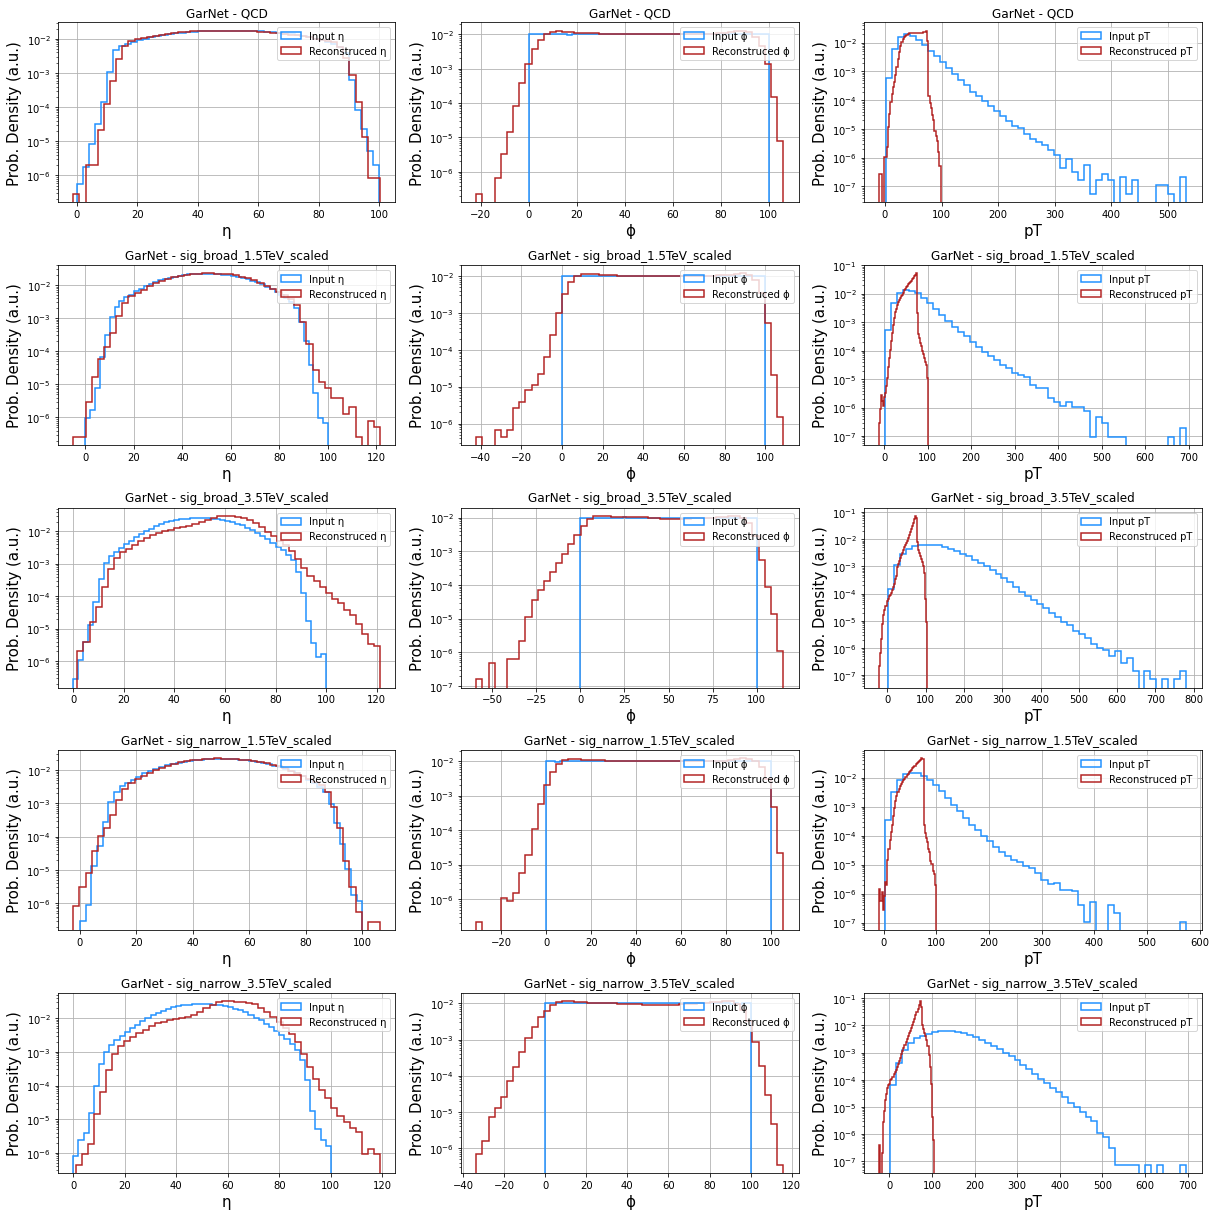

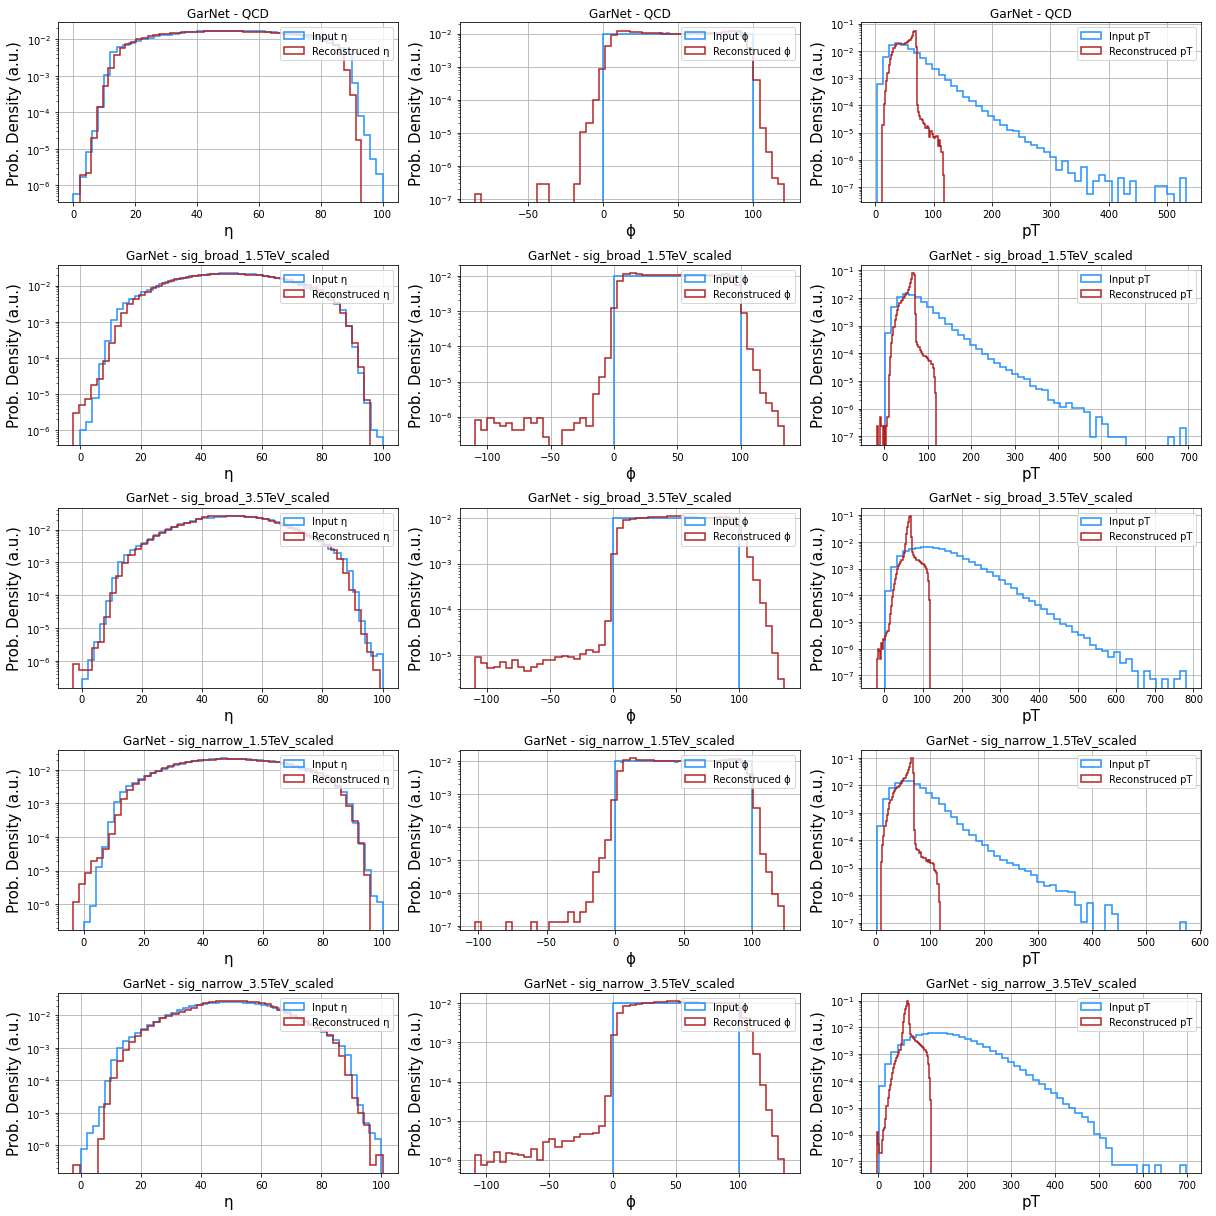

In [15]:
def plot_features1d(model_output, title, signals_loc):

    fig, axs = plt.subplots(len(signals_loc)+1, len(features), figsize=(17,17))

    for i, f in enumerate(["QCD"]+signals_loc):
        if f == "QCD":
            input_data = model_output[f][()]
        else:
            input_data = h5py.File(f, 'r')["jetConstituentsList"][()]

        predicted_data = model_output["predicted_"+Path(f).stem][()]

        for j, feature in enumerate(features):

            ax = axs[i][j]
            
            ax.hist(np.squeeze(input_data[:,:,j][:,j].flatten()), 50, label="Input %s"%feature, density=True, 
                histtype='step', fill=False, linewidth=1.5, color="dodgerblue")

            ax.hist(np.squeeze(predicted_data[:,:,j][:,j].flatten()), 50, label="Reconstruced %s"%feature, density=True,
                histtype='step', fill=False, linewidth=1.5, color="firebrick")
            
            ax.set_yscale('log', nonpositive='clip')     
            ax.set_xlabel(feature, fontsize=15)
            ax.set_ylabel('Prob. Density (a.u.)', fontsize=15)
            ax.set_title("%s - %s"%(title, Path(f).stem))
            ax.grid(True)
            ax.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

for model in models:
    plot_features1d(model[1], model[0], model[2])

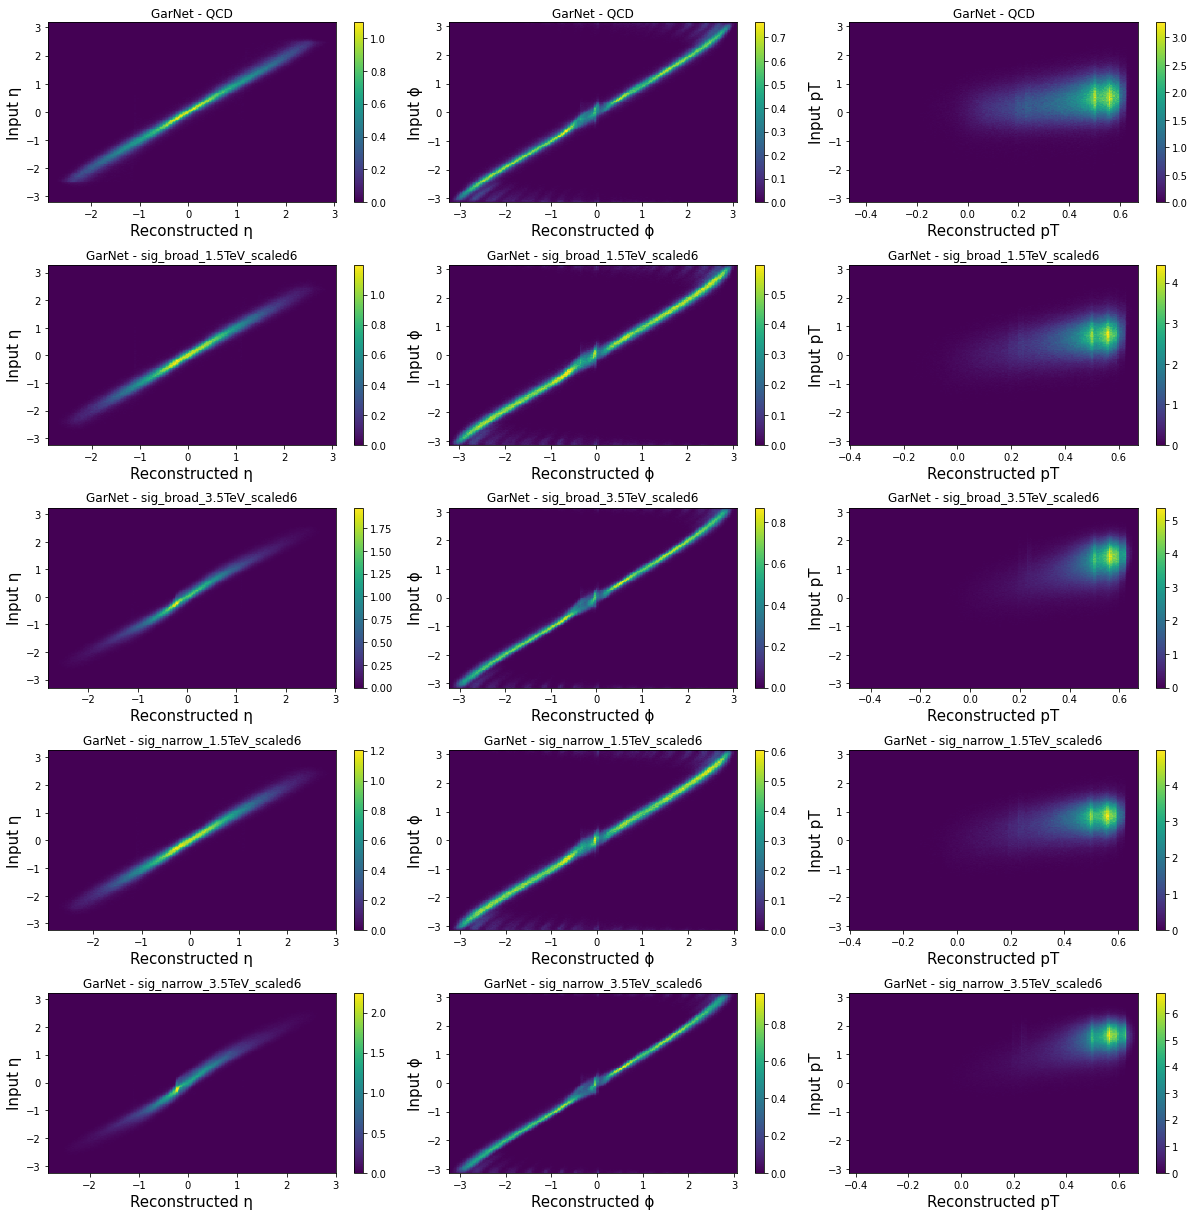

In [5]:
def plot_features2d(model_output, title, signals_loc):

    fig, axs =  plt.subplots(len(signals_loc)+1, len(features), figsize=(17,17))

    for i, f in enumerate(["QCD"]+signals_loc):
        if f == "QCD":
            input_data = model_output[f][()]
        else:
            input_data = h5py.File(f, 'r')["jetConstituentsList"][()]

        predicted_data = model_output["predicted_"+Path(f).stem][()]
        np.expand_dims(np.reshape(predicted_data, (np.shape(predicted_data)[0],) + (16, 3)), axis=3)

        for j, feature in enumerate(features):

            ax = axs[i][j]

            x = np.squeeze(predicted_data[:,:,j][:,j])
            y = np.squeeze(input_data[:,:,j][:,j])
            
            plot = ax.hist2d(x, y, bins=200, density=True)
            
            ax.set_xlabel("Reconstructed {}".format(feature), fontsize=15)
            ax.set_ylabel('Input {}'.format(feature), fontsize=15)
            ax.set_title("%s - %s"%(title, Path(f).stem))
            fig.colorbar(plot[3], ax=ax)

    fig.tight_layout()
    plt.show()

for model in models:
    plot_features2d(model[1], model[0], model[2])

In [6]:
def mse_loss(inputs, outputs):
    return np.mean((inputs-outputs)*(inputs-outputs), axis=-1)

loss = mse_loss

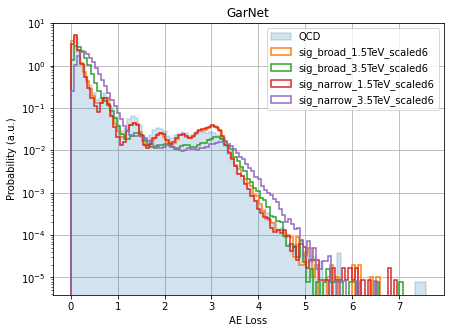

In [7]:
def ae_loss(model_output, title, signals_loc):
    plt.figure()

    for f in ["QCD"]+signals_loc:
        
        if f == "QCD":
            fill, alpha = [True, 0.2]
            inval = model_output[f][()]
            name = f
        else:
            fill, alpha = [False, 1]
            inval = h5py.File(f, 'r')["jetConstituentsList"][()]
            name = Path(f).stem

        outval = model_output["predicted_"+name][()]
        np.expand_dims(np.reshape(outval, (np.shape(outval)[0],) + (16, 3)), axis=3)

        lossQCD = loss(np.reshape(inval, [-1, 16*3*1]), np.reshape(outval, [-1, 16*3*1]))
        maxScore = np.max(lossQCD)

        # plot AE Loss
        plt.hist(lossQCD, bins=100, label=name, density=True, range=(0, maxScore), 
                 histtype='step', fill=fill, alpha=alpha, linewidth=1.5)

    plt.semilogy()
    plt.title(title)
    plt.xlabel("AE Loss")
    plt.ylabel("Probability (a.u.)")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()

for model in models:
    ae_loss(model[1], model[0], model[2])

In [8]:
def metrics(model_output, signals_loc):
    lossQCD = loss(np.reshape(model_output["QCD"][()], [-1, 16*3*1]), np.reshape(model_output["predicted_QCD"][()], [-1, 16*3*1]))
    
    metrics = []
    
    for f in signals_loc:
        name = Path(f).stem
        
        anomaly = h5py.File(f, 'r')["jetConstituentsList"][()]
        loss_anomaly = loss(np.reshape(anomaly, [-1, 16*3*1]), np.reshape(model_output["predicted_"+name][()], [-1, 16*3*1]))

        true_val = np.concatenate((np.ones(loss_anomaly.shape[0]), np.zeros(lossQCD.shape[0])))
        pred_val = np.concatenate((loss_anomaly, lossQCD))

        fpr, tpr, threshold = roc_curve(true_val, pred_val)
        auc_data = auc(fpr, tpr)
        
        metrics.append([name, fpr, tpr, auc_data])
    
    return np.array(metrics, dtype=object)

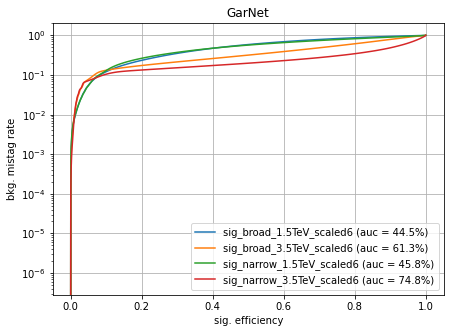

In [9]:
def plot_roc(model_output, title, signals_loc):
    for sig_metrics in metrics(model_output, signals_loc):

        plt.plot(sig_metrics[2], sig_metrics[1], label="%s (auc = %.1f%%)"%(sig_metrics[0], sig_metrics[3]*100.))

        plt.semilogy()
        plt.title(title)
        plt.xlabel("sig. efficiency")
        plt.ylabel("bkg. mistag rate")
        plt.grid(True)
        plt.legend(loc="lower right")
         
    plt.show()
    
for model in models:
    plot_roc(model[1], model[0], model[2])

In [10]:
def ratios(base_output, signals_loc):
    model_output = h5py.File(base_output, "r")
    base = metrics(model_output, glob.glob(signals_loc))
    plt.hlines(1, 1, 17, linestyles='--', color='#ef5675', linewidth=1.5)
    plt.ylim(0.7, 1.3)

    for i in range(2, 17, 2):
        model_output_qp = h5py.File("output/cnn_qp"+str(i)+"/output.h5", "r")
        bits = metrics(model_output_qp, signals_loc)
        plt.scatter([i]*len(base), bits[:, 3]/base[:, 3])

    # plt.legend()
    plt.xlabel("Bit Width")
    plt.ylabel("Sig. AUC / Base AUC")
    plt.title("Bit Ratios")
    plt.show()

# ratios("../output/cnn/output.h5", "../signals_old/*")